### **So sánh Tính năng của các Mô hình AI: CLIP, BLIP và ALIGN**

Notebook này sẽ thực hiện so sánh ba mô hình thị giác-ngôn ngữ (vision-language) nổi bật:
1.  **CLIP** (OpenAI): Mạnh mẽ trong các tác vụ truy xuất và phân loại zero-shot.
2.  **BLIP** (Salesforce): Linh hoạt, có khả năng hiểu và tạo sinh (ví dụ: tạo chú thích).
3.  **ALIGN** (Google): Khả năng tổng quát hóa cao với dữ liệu web nhiễu.

Chúng ta sẽ so sánh chúng trên hai tác vụ chính:
*   **Truy xuất Ảnh-Văn bản (Image-Text Retrieval)**: Đánh giá mô hình nào nhận dạng đúng nhất mô tả cho một hình ảnh.
*   **Tạo Chú thích cho Ảnh (Image Captioning)**: Xem khả năng tạo sinh văn bản của mô hình.

Môi trường chạy notebook: Kaggle, GPU T4 x2

In [1]:
!pip install transformers torch pillow requests --quiet

2025-06-24 02:29:03.232005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750732143.256481     201 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750732143.263312     201 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


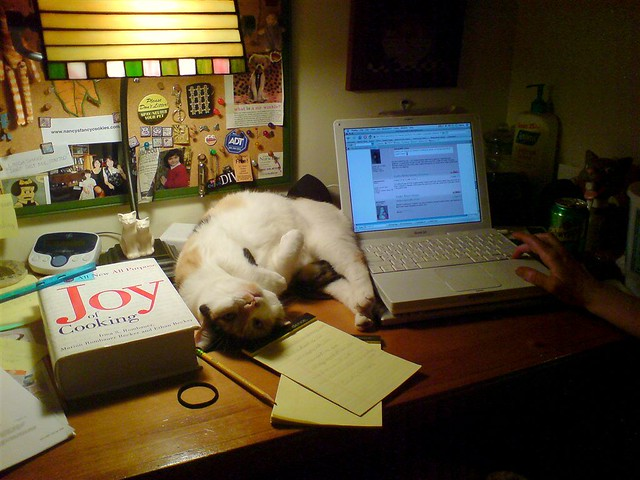

In [2]:
import torch
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel, BlipProcessor, BlipForConditionalGeneration, AlignProcessor, AlignModel

# URL của hình ảnh mẫu
url = "https://farm1.staticflickr.com/189/475765095_c4ef659819_z.jpg"
# Tải và mở hình ảnh
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

# Các câu văn bản để so sánh
texts = ["a photo of a cat", "a photo of a dog", "cat lying between laptop computer and book on small desk."]

# Hiển thị hình ảnh
display(image)

In [3]:
# Tải và sử dụng mô hình CLIP
# Tải model và processor của CLIP
model_id_clip = "openai/clip-vit-base-patch32"
processor_clip = CLIPProcessor.from_pretrained(model_id_clip)
model_clip = CLIPModel.from_pretrained(model_id_clip)

# Chuẩn bị đầu vào
inputs_clip = processor_clip(text=texts, images=image, return_tensors="pt", padding=True)

# Lấy đầu ra là logits so sánh độ tương đồng giữa ảnh và từng câu văn bản
outputs_clip = model_clip(**inputs_clip)
logits_per_image = outputs_clip.logits_per_image  # Biểu diễn sự tương đồng
probs = logits_per_image.softmax(dim=1)  # Chuyển thành xác suất

print("CLIP - So sánh độ tương đồng Ảnh-Văn bản:")
for i, text in enumerate(texts):
    print(f"- '{text}': {probs[0][i].item():.4f}")

# Kết quả cho thấy câu "cat lying between laptop computer and book on small desk" 
# có độ tương đồng cao nhất.

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIP - So sánh độ tương đồng Ảnh-Văn bản:
- 'a photo of a cat': 0.0228
- 'a photo of a dog': 0.0020
- 'cat lying between laptop computer and book on small desk.': 0.9752


In [4]:
# Tải và sử dụng mô hình BLIP
# Tải model và processor của BLIP cho tác vụ tạo chú thích
processor_blip = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Cần tải một model BLIP khác được huấn luyện cho VQA
from transformers import BlipProcessor, BlipForQuestionAnswering

processor_vqa = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model_vqa = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# --- Tính năng 1: Tạo chú thích cho ảnh ---
print("\nBLIP - Tạo chú thích ảnh (Image Captioning):")
inputs_caption = processor_blip(images=image, return_tensors="pt")
outputs_caption = model_blip.generate(**inputs_caption, max_length=50)
caption = processor_blip.decode(outputs_caption[0], skip_special_tokens=True)
print(f"Chú thích được tạo ra: {caption}")

# --- Tính năng 2: Trả lời câu hỏi về hình ảnh (Visual Question Answering) ---

print("\nBLIP - Trả lời câu hỏi (Visual Question Answering):")
question = "How many cats are there?"
inputs_vqa = processor_vqa(images=image, text=question, return_tensors="pt")

outputs_vqa = model_vqa.generate(**inputs_vqa)
answer = processor_vqa.decode(outputs_vqa[0], skip_special_tokens=True)
print(f"Câu hỏi: {question}")
print(f"Trả lời: {answer}")

question = "What is the cat's color?"
inputs_vqa = processor_vqa(images=image, text=question, return_tensors="pt")
outputs_vqa = model_vqa.generate(**inputs_vqa)
answer = processor_vqa.decode(outputs_vqa[0], skip_special_tokens=True)
print(f"Câu hỏi: {question}")
print(f"Trả lời: {answer}")


BLIP - Tạo chú thích ảnh (Image Captioning):
Chú thích được tạo ra: a cat is sleeping on a desk with a laptop

BLIP - Trả lời câu hỏi (Visual Question Answering):
Câu hỏi: How many cats are there?
Trả lời: 1
Câu hỏi: What is the cat's color?
Trả lời: white


In [5]:
# Tải và sử dụng mô hình ALIGN
# Tải model và processor của ALIGN
model_id_align = "kakaobrain/align-base"
processor_align = AlignProcessor.from_pretrained(model_id_align)
model_align = AlignModel.from_pretrained(model_id_align)

# Chuẩn bị đầu vào
inputs_align = processor_align(text=texts, images=image, return_tensors="pt", padding=True)

# Lấy đầu ra là logits so sánh độ tương đồng
outputs_align = model_align(**inputs_align)
logits_per_image_align = outputs_align.logits_per_image
probs_align = logits_per_image_align.softmax(dim=1)

print("\nALIGN - So sánh độ tương đồng Ảnh-Văn bản:")
for i, text in enumerate(texts):
    print(f"- '{text}': {probs_align[0][i].item():.4f}")

# Kết quả cũng cho thấy sự tương đồng cao với câu mô tả đúng nội dung ảnh.

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(



ALIGN - So sánh độ tương đồng Ảnh-Văn bản:
- 'a photo of a cat': 0.0018
- 'a photo of a dog': 0.0000
- 'cat lying between laptop computer and book on small desk.': 0.9982
